In [1]:
! pip install matplotlib
! pip install networkx
! pip install pydot

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import pydot
import numpy as np
from itertools import product
from collections import deque

In [3]:
graph = nx.DiGraph()
tree = [(4, 5, 1.0), (4, 6, 4.6), (5, 0, 3.2), (5, 1, 2.2), (6, 2, 0.1), (6, 3, 2.4)]
for parent, child, weight in tree:
    graph.add_edge(parent, child, weight=weight)


/tmp/ipykernel_38974/1549924494.py:1: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")


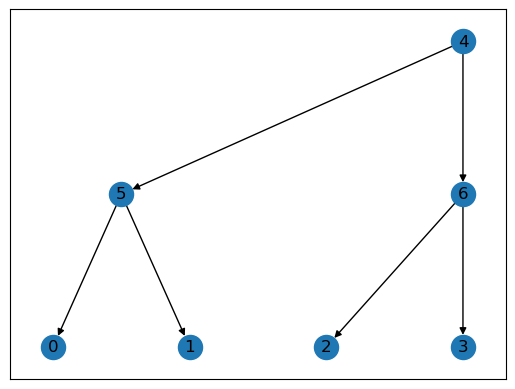

In [4]:
pos = graphviz_layout(graph, prog="dot")
nx.draw_networkx(graph, pos, with_labels=True)
plt.show()

In [5]:
list(graph.successors(0))

[]

In [6]:
graph.nodes[0]['sequence'] = 'ATGG'
graph.nodes[1]['sequence'] = 'ATGC'
graph.nodes[2]['sequence'] = 'CTGG'
graph.nodes[3]['sequence'] = 'ATTG'


In [7]:
def substitution_matrix (alpha, time):
  r_t = 1/4 * (1 + 3 * np.exp(-4 * alpha * time))
  s_t = 1/4 * (1 - np.exp(-4 * alpha * time))
  matrix = np.ones((4, 4), dtype=float)
  matrix *= s_t
  np.fill_diagonal(matrix, r_t)
  return matrix


In [8]:
substitution_matrix(0.01, 5)

array([[0.86404806, 0.04531731, 0.04531731, 0.04531731],
       [0.04531731, 0.86404806, 0.04531731, 0.04531731],
       [0.04531731, 0.04531731, 0.86404806, 0.04531731],
       [0.04531731, 0.04531731, 0.04531731, 0.86404806]])

In [9]:
def initial_probs ():
  return np.ones(4, dtype=float) * 1/4

In [10]:
nucl_to_ind_dict = {'A': 0, 'T': 1, 'G': 2, 'C':3}
ind_to_nucl_dict = {value: key for key, value in nucl_to_ind_dict.items()}
nucls = list(nucl_to_ind_dict.keys())

def likelihood_prob (l_nucl, r_nucl, l_time, r_time):
  s_l = substitution_matrix(0.01, l_time)
  s_r = substitution_matrix(0.01, r_time)
  init_probs = initial_probs()
  likelihood = 0


  l_nucl_ind = nucl_to_ind_dict[l_nucl]
  r_nucl_ind = nucl_to_ind_dict[r_nucl]

  for nucl in nucls:
    nucl_ind = nucl_to_ind_dict[nucl]
    likelihood += init_probs[nucl_ind] * s_l[nucl_ind, l_nucl_ind] *  s_r[nucl_ind, r_nucl_ind]

  return likelihood



In [11]:
def full_log_likelihood (l_seq, r_seq, l_time, r_time):
  log_likelihood = 0
  for nucl_left, nucl_right in zip(l_seq, r_seq):
    log_likelihood += np.log(likelihood_prob(nucl_left, nucl_right, l_time, r_time))

  return log_likelihood



In [12]:
full_log_likelihood('ACTGGGG', 'GGTCCCA', 0.005, 0.015)

-60.81021945632898

In [13]:
full_log_likelihood('ACTGGGG', 'GGTCCCA', 0.01, 0.01)

-60.81021945632901

In [14]:
sequence_length = len('ACTG')
for node, data in graph.nodes(data=True):
  data['likelihood_matrix'] = np.zeros((sequence_length, len(nucls)), dtype=float)

In [15]:
list(graph.successors(4))

[5, 6]

In [16]:
graph.edges[4, 6]['weight']

4.6

In [17]:
alpha = 0.00001
def Felselstein_step(graph, k_node, a_nucl, position_nucl):
  a_nucl_ind = nucl_to_ind_dict[a_nucl]
  if len(list(graph.successors(k_node))) == 0:
    if graph.nodes[k_node]['sequence'][position_nucl] == a_nucl:
      graph.nodes[k_node]['likelihood_matrix'][position_nucl, a_nucl_ind] = 1
    else:
      graph.nodes[k_node]['likelihood_matrix'][position_nucl, a_nucl_ind] = 0

  else:
    graph.nodes[k_node]['likelihood_matrix'][position_nucl, a_nucl_ind] = 0
    l_successor, r_successor = graph.successors(k_node)
    l_time = graph.edges[k_node, l_successor]['weight']
    r_time = graph.edges[k_node, r_successor]['weight']


    substitution_matrix_left = substitution_matrix(alpha, l_time)
    substitution_matrix_right = substitution_matrix(alpha, r_time)

    for l_nucl, r_nucl in product(nucls, nucls):
      l_nucl_ind = nucl_to_ind_dict[l_nucl]
      r_nucl_ind = nucl_to_ind_dict[r_nucl]

      likelihood = substitution_matrix_left[a_nucl_ind, l_nucl_ind] * graph.nodes[l_successor]['likelihood_matrix'][position_nucl, l_nucl_ind] * \
                   substitution_matrix_right[a_nucl_ind, r_nucl_ind] * graph.nodes[r_successor]['likelihood_matrix'][position_nucl, r_nucl_ind]

      graph.nodes[k_node]['likelihood_matrix'][position_nucl, a_nucl_ind] += likelihood



def Felselstein(graph):
  leaf = [node for node in graph.nodes if len(list(graph.successors(node))) == 0][0]
  sequence_length = len(graph.nodes[leaf]['sequence'])
  head = [node for node in graph.nodes if len(list(graph.predecessors(node))) == 0][0]
  nodes_order = list(nx.bfs_layers(graph, head))[::-1]

  for seq_pos in range(sequence_length):
    for layer in nodes_order:
      for node in layer:
        for nucl in nucls:
          Felselstein_step(graph, node, nucl, seq_pos)





In [18]:
Felselstein(graph)

In [19]:
list(nx.bfs_layers(graph, 4))

[[4], [5, 6], [0, 1, 2, 3]]

In [20]:
graph.nodes[5]

{'likelihood_matrix': array([[9.99838015e-01, 7.03923973e-10, 7.03923973e-10, 7.03923973e-10],
        [7.03923973e-10, 9.99838015e-01, 7.03923973e-10, 7.03923973e-10],
        [7.03923973e-10, 7.03923973e-10, 9.99838015e-01, 7.03923973e-10],
        [7.03923973e-10, 7.03923973e-10, 2.19969203e-05, 3.19958403e-05]])}

In [22]:
def v (ind, nucl):
  ...

def w (ind_i, ind_j, nucl_i, nucl_j):
  ...


def g (x):
  ''' Formula 15 '''
  return 2 * x / (1 - np.exp(-2 * x))

def e (seq):
  ''' Formula 30 '''
  v_w_sum = 0
  for i in range(len(seq)):
    v_w_sum += v(i, seq[i])

    for j in range(i + 1, len(seq)):
      v_w_sum += w(i, j, seq[i], seq[j])

  return v_w_sum


def rate (nucl_1, nucl_2):
  ...

def p_rate(seq, ind, nucl):
  ''' Formula 29 '''
  seq_a = seq[:ind] + nucl + seq[ind + 1:]
  return rate(seq[ind], nucl) * g((e(seq_a) - e(seq)) / 2)


def transition_probability(seq_successors, seq_predecessors, length):
  ''' Formula 28 '''
  log_left_product = 0
  log_right_product = 0

  for i, (nucl_successor, nucl_predecessor) in enumerate(zip(seq_successors, seq_predecessors)):
    if nucl_successor != nucl_predecessor:
      log_left_product += np.log() + np.log(length)



In [24]:
class Human:
    def __init__(self, name, age):
        print('Hello from init')
        self.name = name
        self.age = age

    def print_me(self):
        print(f'My name is {self.name} I am {self.age} years old')


In [25]:
a = Human('Sasha', 23)
a.print_me()

Hello from init
My name is Sasha I am 23 years old
